# 机器学习策略演示

本notebook演示如何使用机器学习方法构建一个简单的交易策略。主要步骤包括：

1. 数据获取与预处理
2. 简单因子/特征构造
3. 目标变量（下期收益）的定义
4. 训练简单的线性回归模型
5. 策略回测
6. 使用Backtrader进行回测

## 0. 导入依赖包

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import os
import talib  # 如果报错找不到ta-lib，需先安装并确认本地编译环境
import sys
from dotenv import load_dotenv, find_dotenv
# Find the .env file in the parent directory
dotenv_path = find_dotenv("../../.env")
# Load it explicitly
load_dotenv(dotenv_path)
# Add the parent directory to the sys.path list
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from data_processing import load_data_year, flatten_yf_columns, standardize_columns
from plotting import plot_results
from strategy.buy_and_hold import BuyAndHoldStrategy
from back_test import run_backtest
# 设置显示选项
pd.set_option('display.float_format', lambda x: '%.4f' % x)
# 绘图风格（可选）
plt.style.use('seaborn-v0_8-bright')
# 设置中文显示
plt.rcParams['font.sans-serif'] = ['PingFang HK']
plt.rcParams['axes.unicode_minus'] = False

## 1. 数据获取与预处理

我们获取TSLA过去5年的日线数据。

In [2]:
# 设定时间范围（从现在往前推5年）
end_date = datetime.now()
start_date = end_date - timedelta(days=5*365)
print(f"获取数据时间范围：{start_date.strftime('%Y-%m-%d')} 到 {end_date.strftime('%Y-%m-%d')}")
# 下载特斯拉数据
ticker = 'TSLA'
data = yf.download(ticker, start=start_date, end=end_date)

获取数据时间范围：2020-03-10 到 2025-03-09
YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [3]:
data.head()

Price        Close    High     Low    Open     Volume
Ticker        TSLA    TSLA    TSLA    TSLA       TSLA
Date                                                 
2020-03-10 43.0220 44.5333 40.5333 43.9620  233916000
2020-03-11 42.2820 43.5720 40.8667 42.6800  199837500
2020-03-12 37.3700 39.6333 36.4167 38.7260  283636500
2020-03-13 36.4413 40.5047 33.4667 39.6667  339604500
2020-03-16 29.6713 32.9913 29.4780 31.3000  307342500

## 1.2 数据预处理

In [4]:
data = flatten_yf_columns(data)
data = standardize_columns(data)

In [5]:
print(data.info())              # 看看总共有多少行、列，各字段数据类型
print(data.head(10))           # 查看前10行，确认最早日期
print(data.tail(10))           # 查看后10行，确认最晚日期
print(data.index.min())  # DataFrame中最早的日期
print(data.index.max())  # DataFrame中最晚的日期


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1256 entries, 2020-03-10 to 2025-03-07
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   close   1256 non-null   float64
 1   high    1256 non-null   float64
 2   low     1256 non-null   float64
 3   open    1256 non-null   float64
 4   volume  1256 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 58.9 KB
None
             close    high     low    open     volume
Date                                                 
2020-03-10 43.0220 44.5333 40.5333 43.9620  233916000
2020-03-11 42.2820 43.5720 40.8667 42.6800  199837500
2020-03-12 37.3700 39.6333 36.4167 38.7260  283636500
2020-03-13 36.4413 40.5047 33.4667 39.6667  339604500
2020-03-16 29.6713 32.9913 29.4780 31.3000  307342500
2020-03-17 28.6800 31.4567 26.4000 29.3340  359919000
2020-03-18 24.0813 26.9907 23.3673 25.9333  356793000
2020-03-19 28.5093 30.1333 23.8973 24.9800  452932500
2020-03-20 28.5020 31

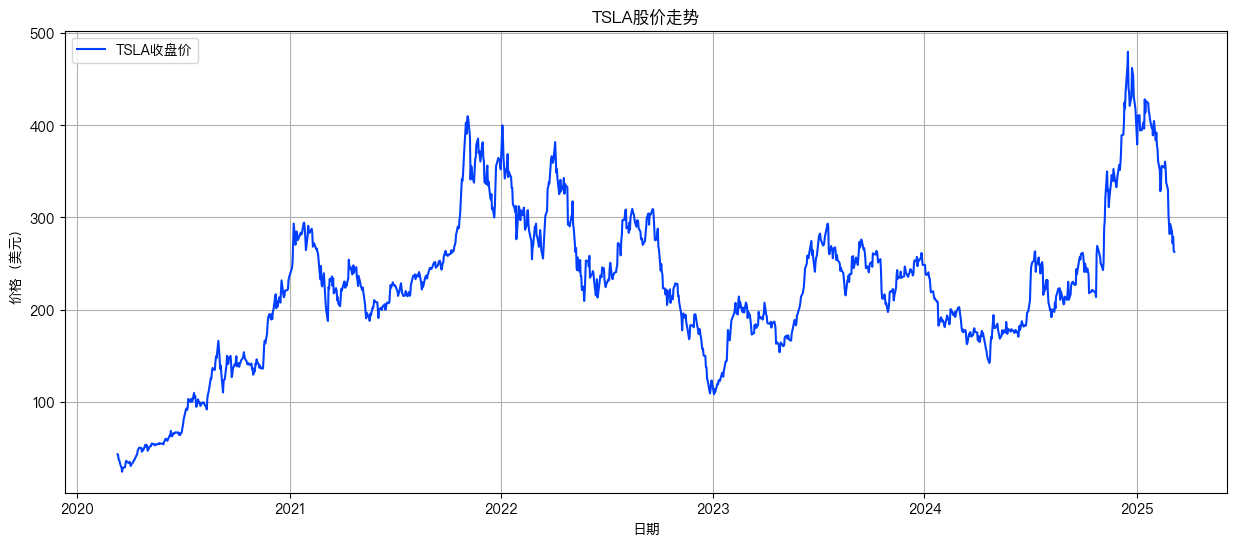

In [6]:
# 绘制收盘价走势图
plt.figure(figsize=(15, 6))
plt.plot(data.index, data['close'], label=f'{ticker}收盘价')
plt.title(f'{ticker}股价走势')
plt.xlabel('日期')
plt.ylabel('价格（美元）')
plt.legend()
plt.grid(True)
plt.show()

## 2. 加入更多技术指标

构建两个简单的因子：
1. 动量因子：过去5日涨跌幅
2. 成交量比值：最近5日均量vs最近10日均量
3. 先举几个常用指标的例子：RSI, MACD, 布林带。

In [7]:
# 复制数据
df = data.copy()
# 动量因子: 过去5日涨跌幅
df['momentum_5'] = df['close'] / df['close'].shift(5) - 1
# 成交量因子: (最近5日平均成交量) / (最近10日平均成交量) - 1
df['vol_ratio'] = (df['volume'].rolling(5).mean()) / (df['volume'].rolling(10).mean()) - 1
df.dropna(inplace=True)  # 丢掉因子无法计算的前几行
factors = ['momentum_5', 'vol_ratio']
# 看看加上技术指标后的DataFrame
print(df[['close'] + factors].tail(5))


              close  momentum_5  vol_ratio
Date                                      
2025-03-03 284.6500     -0.1388     0.2863
2025-03-04 272.0400     -0.1016     0.1697
2025-03-05 279.1000     -0.0402     0.1253
2025-03-06 263.4500     -0.0656     0.0620
2025-03-07 262.6700     -0.1035     0.0085


In [8]:
import math

Data preview with 'close' and factors:
              close  momentum_5  vol_ratio
Date                                      
2025-03-03 284.6500     -0.1388     0.2863
2025-03-04 272.0400     -0.1016     0.1697
2025-03-05 279.1000     -0.0402     0.1253
2025-03-06 263.4500     -0.0656     0.0620
2025-03-07 262.6700     -0.1035     0.0085
因子数据预览：
            momentum_5  vol_ratio
Date                             
2025-02-24     -0.0711    -0.1865
2025-02-25     -0.1449    -0.0432
2025-02-26     -0.1935     0.0598
2025-02-27     -0.2044     0.2026
2025-02-28     -0.1327     0.2645
2025-03-03     -0.1388     0.2863
2025-03-04     -0.1016     0.1697
2025-03-05     -0.0402     0.1253
2025-03-06     -0.0656     0.0620
2025-03-07     -0.1035     0.0085


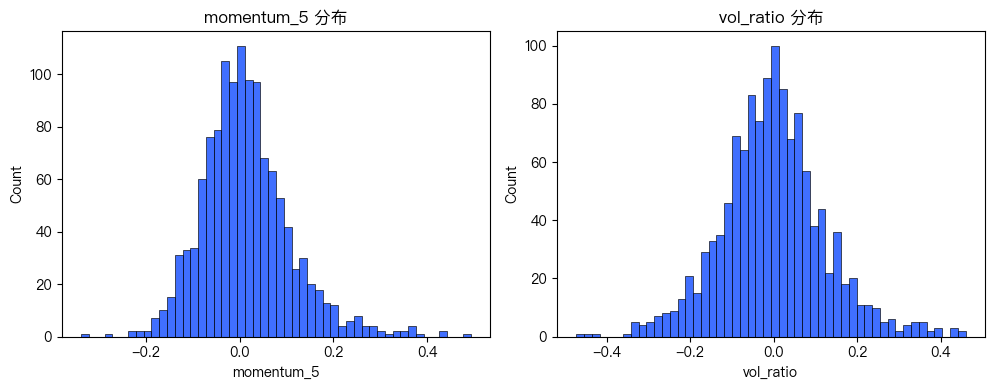

In [9]:
# List of factors to visualize
factors = ['momentum_5', 'vol_ratio']
# 查看包含收盘价和因子的DataFrame数据预览
print("Data preview with 'close' and factors:")
print(df[['close'] + factors].tail(5))
# 查看因子数据预览
print("因子数据预览：")
print(df[factors].tail(10))
# 设置网格布局：确定行数和列数
n_factors = len(factors)
ncols = 3  # You can adjust the number of columns if desired
nrows = math.ceil(n_factors / ncols)
fig, axes = plt.subplots(nrows, ncols, figsize=(5 * ncols, 4 * nrows))
# Flatten the axes array to iterate over them easily
axes = axes.flatten()
# 为每个因子绘制直方图
for i, factor in enumerate(factors):
    sns.histplot(df[factor].dropna(), bins=50, ax=axes[i])
    axes[i].set_title(f'{factor} 分布')
    axes[i].set_xlabel(factor)
# 删除多余的子图（如果有的话）
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])
plt.tight_layout()
plt.show()

## 3. 目标变量的定义

定义下期1日收益率作为目标变量。

添加目标变量后的数据预览：
             close  momentum_5  vol_ratio
Date                                     
2020-03-23 28.9527     -0.0242     0.1486
2020-03-24 33.6667      0.1739     0.1007
2020-03-25 35.9500      0.4929     0.0403
2020-03-26 35.2107      0.2351    -0.0654
2020-03-27 34.2907      0.2031    -0.1571
2020-03-30 33.4753      0.1562    -0.1655
2020-03-31 34.9333      0.0376    -0.1902
2020-04-01 32.1040     -0.1070    -0.2278
2020-04-02 30.2980     -0.1395    -0.1573
2020-04-03 32.0007     -0.0668    -0.0382


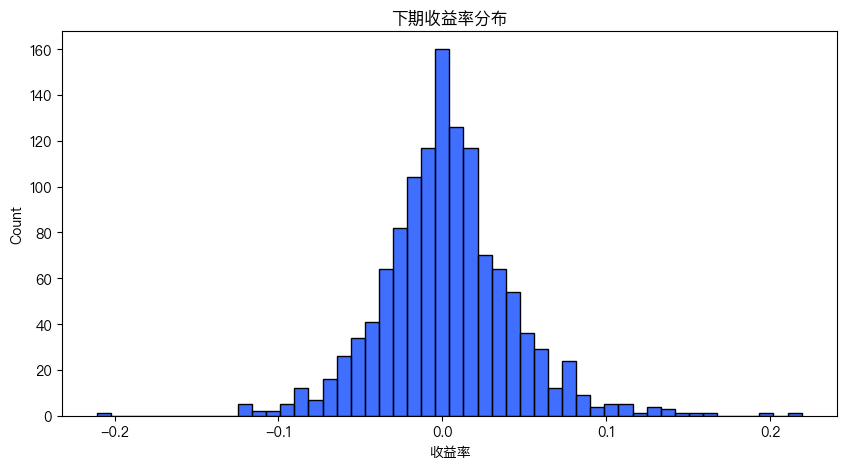

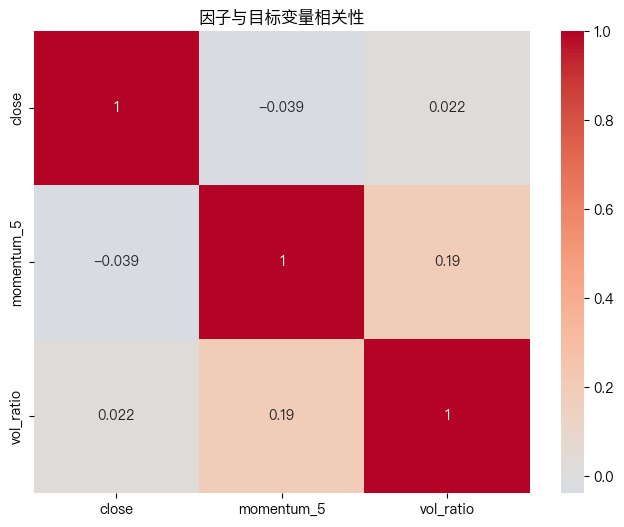

In [10]:
# 计算下期收益率
df['future_ret_1d'] = df['close'].pct_change().shift(-1)
# 去掉NaN值
df.dropna(inplace=True)
print("添加目标变量后的数据预览：")
print(df[['close']+factors].head(10))
# 绘制目标变量分布
plt.figure(figsize=(10, 5))
sns.histplot(df['future_ret_1d'], bins=50)
plt.title('下期收益率分布')
plt.xlabel('收益率')
plt.show()
# 计算因子与目标变量的相关性
corr = df[['close']+factors].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
plt.title('因子与目标变量相关性')
plt.show()

## 4. 划分训练集与测试集

按照时间顺序，使用前80%的数据作为训练集，后20%作为测试集。

训练集范围: 2020-03-23 00:00:00 → 2024-03-06 00:00:00
测试集范围: 2024-03-07 00:00:00 → 2025-03-06 00:00:00

训练集样本数: 996
测试集样本数: 250


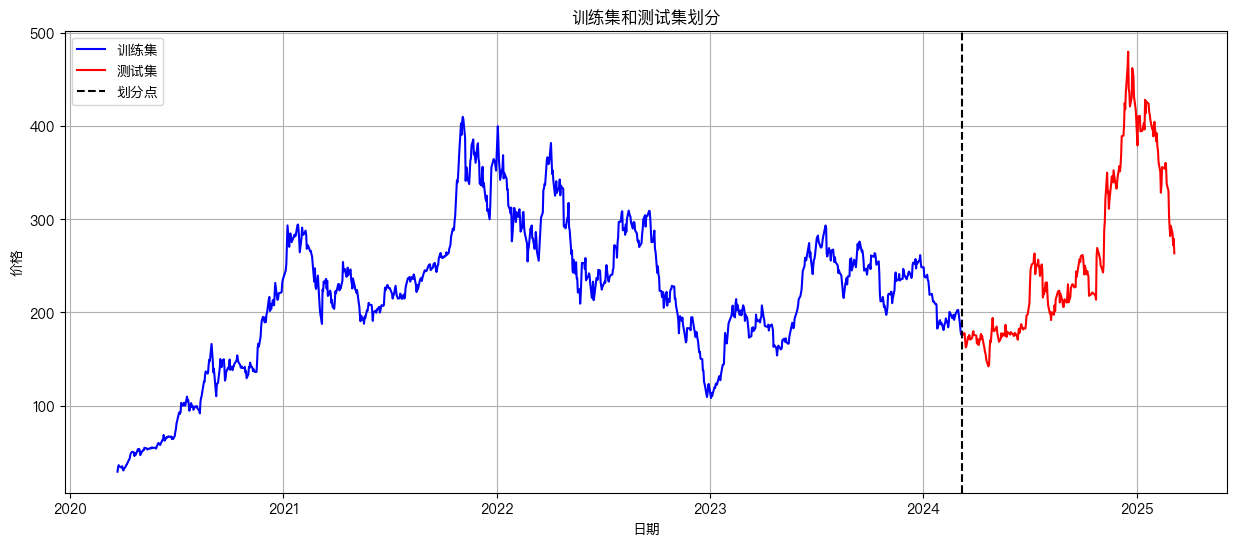

In [11]:
# 计算分割点
split_idx = int(len(df) * 0.8)
split_date = df.index[split_idx]
train_data = df.iloc[:split_idx].copy()
test_data = df.iloc[split_idx:].copy()
print("训练集范围:", train_data.index.min(), "→", train_data.index.max())
print("测试集范围:", test_data.index.min(), "→", test_data.index.max())
print("\n训练集样本数:", len(train_data))
print("测试集样本数:", len(test_data))
# 可视化训练集和测试集的划分
plt.figure(figsize=(15, 6))
plt.plot(train_data.index, train_data['close'], label='训练集', color='blue')
plt.plot(test_data.index, test_data['close'], label='测试集', color='red')
plt.axvline(split_date, color='black', linestyle='--', label='划分点')
plt.title('训练集和测试集划分')
plt.xlabel('日期')
plt.ylabel('价格')
plt.legend()
plt.grid(True)
plt.show()

## 5. 训练线性回归模型

In [12]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
# 从训练集中取X和y
features = factors
X_train = train_data[features].values
y_train = train_data['future_ret_1d'].values
# 同理，测试集
X_test = test_data[features].values
y_test = test_data['future_ret_1d'].values
# 建模
model = LinearRegression()
model.fit(X_train, y_train)
# 预测
y_pred_train = model.predict(X_train)
y_pred_test  = model.predict(X_test)
# 评估 - 用 MSE 举例
train_mse = mean_squared_error(y_train, y_pred_train)
test_mse  = mean_squared_error(y_test, y_pred_test)
print("Train MSE:", train_mse)
print("Test MSE: ", test_mse)
# 查看训练后的回归系数
print("Coefficients:", model.coef_)
print("Intercept:", model.intercept_)
train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)
print("训练集 R2:", train_r2)
print("测试集 R2:", test_r2)


Train MSE: 0.0015753269493530954
Test MSE:  0.001691326001723576
Coefficients: [0.00797439 0.02994764]
Intercept: 0.0025989380573413824
训练集 R2: 0.008648390438617204
测试集 R2: -0.007203786609924823


## 6. 简单对比 

策略评估指标：
策略总收益率: 42.33%
买入持有收益率: 47.47%

策略夏普比率: 0.96
买入持有夏普比率: 0.92

策略最大回撤: -29.28%
买入持有最大回撤: -45.10%


/Users/jhuan196/miniforge3/envs/ta_arm/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


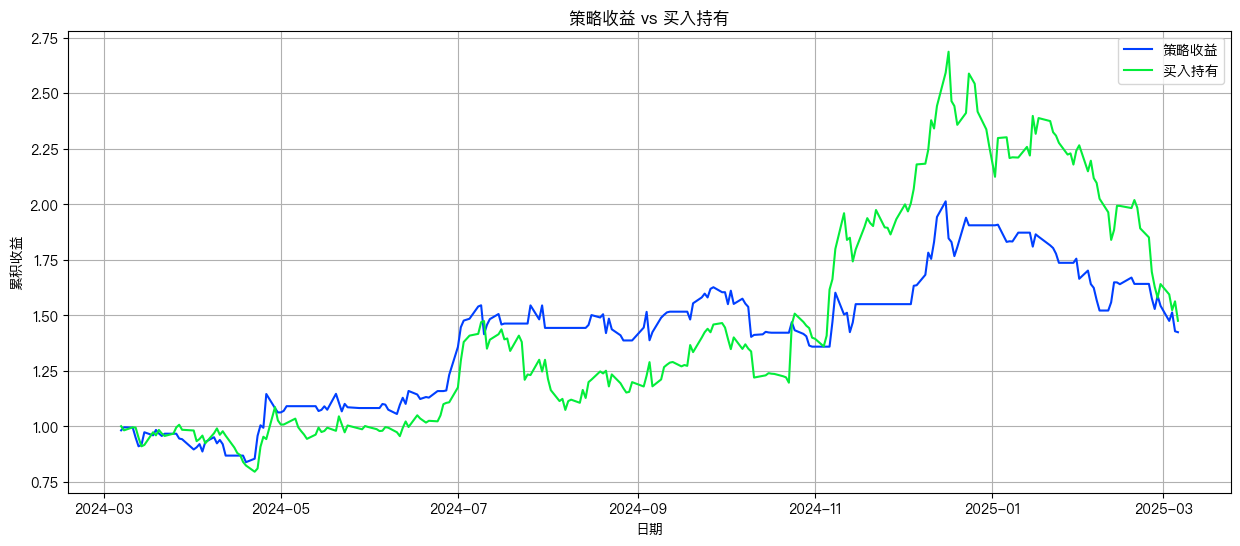

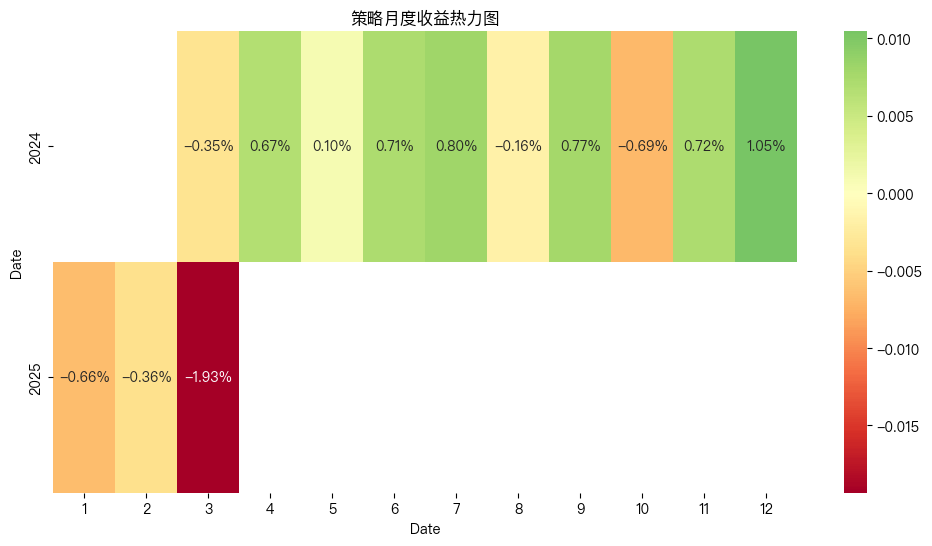

In [13]:
# 在测试集上生成预测
test_data['pred_ret_1d'] = model.predict(test_data[features])
# 生成交易信号
test_data['signal'] = (test_data['pred_ret_1d'] > 0).astype(int)
# 计算策略收益
test_data['strategy_ret'] = test_data['signal'] * test_data['future_ret_1d']
# 计算累积收益
test_data['strategy_cum'] = (1 + test_data['strategy_ret']).cumprod()
test_data['buy_and_hold'] = test_data['close'] / test_data['close'].iloc[0]
# 计算策略评估指标
strategy_return = test_data['strategy_cum'].iloc[-1] - 1
bh_return = test_data['buy_and_hold'].iloc[-1] - 1
strategy_sharpe = np.sqrt(252) * test_data['strategy_ret'].mean() / test_data['strategy_ret'].std()
bh_sharpe = np.sqrt(252) * test_data['close'].pct_change().mean() / test_data['close'].pct_change().std()
strategy_drawdown = (test_data['strategy_cum'] / test_data['strategy_cum'].cummax() - 1).min()
bh_drawdown = (test_data['buy_and_hold'] / test_data['buy_and_hold'].cummax() - 1).min()
print("策略评估指标：")
print(f"策略总收益率: {strategy_return:.2%}")
print(f"买入持有收益率: {bh_return:.2%}")
print(f"\n策略夏普比率: {strategy_sharpe:.2f}")
print(f"买入持有夏普比率: {bh_sharpe:.2f}")
print(f"\n策略最大回撤: {strategy_drawdown:.2%}")
print(f"买入持有最大回撤: {bh_drawdown:.2%}")
# 绘制策略收益曲线
plt.figure(figsize=(15, 6))
plt.plot(test_data.index, test_data['strategy_cum'], label='策略收益')
plt.plot(test_data.index, test_data['buy_and_hold'], label='买入持有')
plt.title('策略收益 vs 买入持有')
plt.xlabel('日期')
plt.ylabel('累积收益')
plt.legend()
plt.grid(True)
plt.show()
# 绘制月度收益热力图
monthly_returns = test_data['strategy_ret'].groupby([test_data.index.year, test_data.index.month]).mean()
monthly_returns = monthly_returns.unstack()
plt.figure(figsize=(12, 6))
sns.heatmap(monthly_returns, annot=True, fmt='.2%', cmap='RdYlGn', center=0)
plt.title('策略月度收益热力图')
plt.show()

## 6. 使用Backtrader进行回测

In [14]:
import backtrader as bt
# 自定义成交量指标，把成交量数据单独显示在子图中
class MyVolumeIndicator(bt.Indicator):
    """
    简单示例，把data的volume包装成一个单独的子图指标。
    """
    lines = ('vol',)
    plotinfo = dict(subplot=True, plotname='Volume')  # 让它单独开子图
    def __init__(self):
        self.lines.vol = self.data.volume
class MLFactorStrategy(bt.Strategy):
    params = (
        ('model', None),            # 预先训练好的机器学习模型
        ('target_percent', 0.98),   # 目标仓位百分比
    )
    def __init__(self):
        self.model = self.p.model
        # 关闭主图中Data自带的Volume绘制
        self.data.plotinfo.plotvolume = False
        # 自定义成交量指标以及其SMA指标
        self.myvol = MyVolumeIndicator(self.data)
        self.vol_5 = bt.indicators.SMA(self.myvol.vol, period=5)
        self.vol_5.plotinfo.subplot = True
        self.vol_10 = bt.indicators.SMA(self.myvol.vol, period=10)
        self.vol_10.plotinfo.subplot = True
        # 添加其它因子指标
        # 价格动量指标：计算5日价格百分比变化
        self.momentum_5 = bt.indicators.PercentChange(self.data.close, period=5)
    def next(self):
        # 计算各个因子的当前值
        momentum = self.momentum_5[0]
        vol_ratio = (self.vol_5[0] / self.vol_10[0] - 1) if self.vol_10[0] != 0 else 0
        # 构建特征向量：注意顺序需要与模型训练时一致
        X = [[momentum, vol_ratio]]
        pred_ret = self.model.predict(X)[0]
        # 根据预测结果决定买卖操作
        if pred_ret > 0:
            self.order_target_percent(target=self.p.target_percent)
            print(f"{self.datas[0].datetime.date(0)} => BUY signal, pred_ret={pred_ret:.6f}")
        else:
            self.order_target_percent(target=0.0)
            print(f"{self.datas[0].datetime.date(0)} => SELL signal, pred_ret={pred_ret:.6f}")
        print(f"Current position size: {self.getposition().size}, Value: {self.broker.getvalue()}")

In [15]:
# 若想看最优参数的详细回测日志，可再手动调用:
final_result, cerebro = run_backtest(
    ticker=ticker,
    df=test_data,
    start_date=start_date,
    end_date=end_date,
    strategy=MLFactorStrategy,
    initial_cash=100000,
    strategy_params={'model': model, 'target_percent':0.98},
    print_log=True,  # 这次打开日志
)


初始资金: 100000.00
2024-03-20 => BUY signal, pred_ret=0.003698
Current position size: 0, Value: 100000.0
2024-03-21 => BUY signal, pred_ret=0.001449
Current position size: 557, Value: 97885.38733989562
2024-03-22 => BUY signal, pred_ret=0.000199
Current position size: 556, Value: 96772.59764081115
2024-03-25 => SELL signal, pred_ret=-0.002113
Current position size: 556, Value: 97773.39933758849
2024-03-26 => SELL signal, pred_ret=-0.000161
Current position size: 0, Value: 100954.53495979308
2024-03-27 => BUY signal, pred_ret=0.000329
Current position size: 0, Value: 100954.53495979308
2024-03-28 => BUY signal, pred_ret=0.002140
Current position size: 550, Value: 99916.40794731138
2024-04-01 => BUY signal, pred_ret=0.003174
Current position size: 557, Value: 99594.67879270019
2024-04-02 => BUY signal, pred_ret=0.005365
Current position size: 557, Value: 94810.05083249511
2024-04-03 => BUY signal, pred_ret=0.002903
Current position size: 557, Value: 95784.80083249511
2024-04-04 => BUY signa

In [16]:
# ===== 猴子补丁：为 numpy 添加 bool8 和 object 属性 =====
import numpy as np
if not hasattr(np, 'bool8'):
    np.bool8 = np.bool_  # 使用 numpy 自带的 bool_ 类型
if not hasattr(np, 'object'):
    np.object = object  # 兼容 backtrader_plotting 的引用

/var/folders/lb/hgfyjd8d6jdgjkfcksmwvbd80000gq/T/ipykernel_3622/1425693070.py:5: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, 'object'):


In [17]:
plot_results(cerebro)

Loading BokehJS ...

# 7. 对比 Buy&Hold 策略

In [18]:
# 若想看最优参数的详细回测日志，可再手动调用:
final_result, cerebro = run_backtest(
    ticker=ticker,
    df=test_data,
    start_date=start_date,
    end_date=end_date,
    strategy=BuyAndHoldStrategy,
    initial_cash=100000,
    print_log=True,  # 这次打开日志
    timeframe=bt.TimeFrame.Days,
    compression=1
)

初始资金: 100000.00
2024-03-07 00:00:00 [买入] 执行买入并持有策略: 价格=178.65, 数量=531
2024-03-08 00:00:00 [成交] 买单执行: 价格=181.55, 数量=531
2025-03-06 00:00:00 [回测结束] Buy & Hold 策略最终市值: 143392.50
2025-03-06 00:00:00 [回测结束] 总收益率: 43.39%
回测结束资金: 143392.50
=== 回测分析报告 ===
夏普比率: 0.8679
最大回撤比例: 44.49%
最大回撤金额(自定义): 114913.70
累计收益率: 36.04%
年化收益率: 43.81%
=== 交易详情 ===
总交易笔数: 1
胜率: 0 / 1


In [42]:
plot_results(cerebro)